In [1]:
!pip install -q transformers datasets evaluate tensorflow tensorflow_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00


In [2]:
import os
import gc
import re
import math
import random
import time
import warnings
import copy

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForMaskedLM,
    get_linear_schedule_with_warmup
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    precision_recall_fscore_support,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score
)

import tensorflow_hub as hub

os.environ["TOKENIZERS_PARALLELISM"] = "false"

2026-02-22 22:44:08.745552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771800248.946160      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771800248.996478      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771800249.432556      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771800249.432608      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771800249.432612      24 computation_placer.cc:177] computation placer alr

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [4]:
class TemporalCNN(nn.Module):
    """
    Temporal CNN applied across the sequence (time) dimension.
    Input: sequence_embeddings (B, L, H), attention_mask (B, L)
    Output: pooled vector (B, output_dim) where output_dim = num_filters * len(kernel_sizes) * 2
            (we concatenate max-pooled and mean-pooled features for each kernel size)
    """
    def __init__(self, input_dim=768, num_filters=256, kernel_sizes=(2,3,4), dropout=0.3):
        super().__init__()
        self.input_dim = input_dim
        self.num_filters = num_filters
        self.kernel_sizes = kernel_sizes

        # Convs expect (B, C_in, L) where C_in = input_dim
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=input_dim, out_channels=num_filters, kernel_size=k, padding=k//2)
            for k in kernel_sizes
        ])
        self.dropout = nn.Dropout(dropout)

    def forward(self, sequence_embeddings, attention_mask=None):
        """
        sequence_embeddings: (B, L, H)
        attention_mask: (B, L) with 1 for valid tokens, 0 for padding
        returns: (B, num_filters * len(kernel_sizes) * 2)  # max + mean pooled per conv
        """
        # transpose to (B, H, L)
        x = sequence_embeddings.transpose(1, 2).contiguous()  # (B, H, L)
    
        pooled_outputs = []
        for conv in self.convs:
            conv_out = conv(x)                # (B, num_filters, L_out)
            conv_out = F.relu(conv_out)
            L_out = conv_out.size(2)
    
            if attention_mask is not None:
                # resize mask to match L_out
                mask = attention_mask.float()
                if mask.size(1) != L_out:
                    mask = F.interpolate(mask.unsqueeze(1), size=L_out, mode='nearest').squeeze(1)
                mask = mask.unsqueeze(1).to(conv_out.device)  # (B,1,L_out)
    
                # max pool with masking
                neg_inf = torch.finfo(conv_out.dtype).min / 2
                max_masked = torch.where(mask.bool(), conv_out, neg_inf*torch.ones_like(conv_out))
                max_pooled = torch.max(max_masked, dim=2)[0]  # (B, num_filters)
    
                # mean pool with masking
                sum_masked = (conv_out * mask).sum(dim=2)    # (B, num_filters)
                denom = mask.sum(dim=2).clamp_min(1e-6)     # (B,1)
                mean_pooled = sum_masked / denom            # (B, num_filters)
            else:
                max_pooled = torch.max(conv_out, dim=2)[0]
                mean_pooled = conv_out.mean(dim=2)
    
            pooled_outputs.append(max_pooled)
            pooled_outputs.append(mean_pooled)
    
        out = torch.cat(pooled_outputs, dim=1)  # (B, num_filters * len(kernel_sizes) * 2)
        out = self.dropout(out)
        return out



In [5]:
def visualize_rationales(tokenizer, input_ids_batch, attention_mask_batch, rationale_scores_batch,
                         labels_true=None, labels_pred=None, probs=None, n_samples=5):
    """
    Print token-level rationale scores for the first few test samples.
    """
    for i in range(min(n_samples, len(input_ids_batch))):
        input_ids = input_ids_batch[i]
        attn_mask = attention_mask_batch[i]
        scores = rationale_scores_batch[i]

        tokens = tokenizer.convert_ids_to_tokens(input_ids[attn_mask.bool()])
        scores = scores[attn_mask.bool()]

        prob_str = f"{probs[i]:.3f}" if probs is not None else "N/A"
        true_label = labels_true[i] if labels_true is not None else "?"
        pred_label = labels_pred[i] if labels_pred is not None else "?"

        print(f"Sample {i} | True: {true_label} | Pred: {pred_label} | Prob: {prob_str}")
        for tok, score in zip(tokens, scores):
            if isinstance(score, torch.Tensor):
                score = score.item()
            print(f"{tok:<15} : {score:.3f}")
        print()

In [6]:
class MultiScaleAttentionCNN(nn.Module):
    def __init__(self, hidden_size=768, num_filters=64,
                 kernel_sizes=(2,3,4,5,6,7), dropout=0.3):
        super().__init__()

        self.hidden_size = hidden_size
        self.kernel_sizes = kernel_sizes

        self.convs = nn.ModuleList()
        self.pads  = nn.ModuleList()

        for k in self.kernel_sizes:
            # compute correct SAME padding
            pad_left  = (k - 1) // 2
            pad_right = k - 1 - pad_left

            # asymmetric padding
            self.pads.append(nn.ConstantPad1d((pad_left, pad_right), 0.0))

            # conv with no padding (padding=0)
            self.convs.append(
                nn.Conv1d(hidden_size, num_filters, kernel_size=k, padding=0)
            )

        self.attn = nn.ModuleList([nn.Linear(num_filters, 1) for _ in self.kernel_sizes])
        self.output_size = num_filters * len(self.kernel_sizes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, hidden_states, mask):
        """
        hidden_states: (B, L, H)
        mask:          (B, L)
        """
        x = hidden_states.transpose(1, 2)  # (B, H, L)
        attn_mask = mask.unsqueeze(1).float()

        conv_outs = []

        for pad, conv, att in zip(self.pads, self.convs, self.attn):
            padded = pad(x)      # (B, H, L) EXACT SAME LENGTH as input
            c = conv(padded)     # (B, F, L)
            c = F.relu(c)
            c = c * attn_mask

            c_t = c.transpose(1, 2)    # (B, L, F)
            w = att(c_t)               # (B, L, 1)
            w = w.masked_fill(mask.unsqueeze(-1) == 0, -1e9)
            w = F.softmax(w, dim=1)

            pooled = (c_t * w).sum(dim=1)   # (B, F)
            conv_outs.append(pooled)

        out = torch.cat(conv_outs, dim=1)   # (B, F * K)
        return self.dropout(out)


In [7]:
class AdditionalCustomDataset(Dataset):
    def __init__(self, texts, labels, rationales, tokenizer, bert_tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.rationales = rationales
        self.tokenizer = tokenizer            # tokenizer for HateBERT (original text)
        self.bert_tokenizer = bert_tokenizer  # tokenizer for rationale text
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        rationale_text = str(self.rationales[idx]) if (self.rationales is not None) else ""
        label = int(self.labels[idx])

        enc = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt',
            return_attention_mask=True
        )
        add_enc = self.bert_tokenizer(
            rationale_text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt',
            return_attention_mask=True
        )

        input_ids = enc['input_ids'].squeeze(0)
        attention_mask = enc['attention_mask'].squeeze(0)
        additional_input_ids = add_enc['input_ids'].squeeze(0)
        additional_attention_mask = add_enc['attention_mask'].squeeze(0)

        # Build token-level rationale mask by token-string overlap
        orig_tokens = self.tokenizer.convert_ids_to_tokens(input_ids.tolist())
        rat_tokens = set([t for t in self.bert_tokenizer.convert_ids_to_tokens(additional_input_ids.tolist()) if t not in (self.bert_tokenizer.pad_token, None)])
        rationale_mask = torch.zeros(self.max_length, dtype=torch.float)
        for i, tok in enumerate(orig_tokens):
            if i >= self.max_length:
                break
            if tok in rat_tokens and tok not in (self.tokenizer.pad_token, None):
                rationale_mask[i] = 1.0

        # ensure we don't mark PAD positions
        pad_id = self.tokenizer.pad_token_id
        if pad_id is not None:
            pad_positions = (input_ids == pad_id).nonzero(as_tuple=True)[0]
            for p in pad_positions:
                rationale_mask[p] = 0.0

        return input_ids, attention_mask, additional_input_ids, additional_attention_mask, torch.tensor(label, dtype=torch.long), rationale_mask



In [8]:
class ProjectionMLP(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_labels=2):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_labels)
        )
    def forward(self, x):
        return self.layers(x)

In [9]:
class ConcatModelWithRationale(nn.Module):
    def __init__(self,
                 hatebert_model,
                 additional_model,
                 projection_mlp,
                 hidden_size=768,
                 gumbel_temp=0.5,
                 freeze_additional_model=True,
                 cnn_num_filters=64,
                 cnn_kernel_sizes=(2,3,4,5,6,7),
                 cnn_dropout=0.0):
        super().__init__()
        self.hatebert_model = hatebert_model
        self.additional_model = additional_model
        self.projection_mlp = projection_mlp
        self.gumbel_temp = gumbel_temp
        self.hidden_size = hidden_size

        # freeze additional_model if requested
        if freeze_additional_model:
            for param in self.additional_model.parameters():
                param.requires_grad = False

        # selector head (per-token logits)
        self.selector = nn.Linear(hidden_size, 1)

        # Temporal CNN over HateBERT embeddings (main text)
        self.temporal_cnn = TemporalCNN(input_dim=hidden_size,
                                        num_filters=cnn_num_filters,
                                        kernel_sizes=cnn_kernel_sizes,
                                        dropout=cnn_dropout)
        self.temporal_out_dim = cnn_num_filters * len(cnn_kernel_sizes) * 2

        # MultiScaleAttentionCNN over rationale embeddings (frozen BERT)
        self.msa_cnn = MultiScaleAttentionCNN(hidden_size=hidden_size,
                                              num_filters=cnn_num_filters,
                                              kernel_sizes=cnn_kernel_sizes,
                                              dropout=cnn_dropout)
        self.msa_out_dim = self.msa_cnn.output_size

    def gumbel_sigmoid_sample(self, logits):
        noise = -torch.log(-torch.log(torch.rand_like(logits) + 1e-9) + 1e-9)
        y = logits + noise
        return torch.sigmoid(y / self.gumbel_temp)

    def forward(self, input_ids, attention_mask, additional_input_ids, additional_attention_mask, return_attentions=False):
        # Main text through HateBERT
        hatebert_out = self.hatebert_model(input_ids=input_ids,
                                           attention_mask=attention_mask,
                                           output_attentions=return_attentions,
                                           return_dict=True)
        hatebert_emb = hatebert_out.last_hidden_state   # (B, L, H)
        cls_emb = hatebert_emb[:, 0, :]                 # (B, H)

        # Rationale text through frozen BERT
        with torch.no_grad():
            add_out = self.additional_model(input_ids=additional_input_ids,
                                            attention_mask=additional_attention_mask,
                                            return_dict=True)
            rationale_emb = add_out.last_hidden_state   # (B, L, H)

        # selector logits & Gumbel-Sigmoid sampling on HateBERT
        selector_logits = self.selector(hatebert_emb).squeeze(-1)  # (B, L)
        rationale_probs = self.gumbel_sigmoid_sample(selector_logits)  # (B, L)
        rationale_probs = rationale_probs * attention_mask.float().to(rationale_probs.device)

        # pooled rationale summary
        masked_hidden = hatebert_emb * rationale_probs.unsqueeze(-1)
        denom = rationale_probs.sum(1).unsqueeze(-1).clamp_min(1e-6)
        pooled_rationale = masked_hidden.sum(1) / denom  # (B, H)

        # CNN branches
        temporal_features = self.temporal_cnn(hatebert_emb, attention_mask)           # (B, temporal_out_dim)
        rationale_features = self.msa_cnn(rationale_emb, additional_attention_mask)   # (B, msa_out_dim)

        # concat CLS + CNN features + pooled rationale
        concat_emb = torch.cat((cls_emb, temporal_features, rationale_features, pooled_rationale), dim=1)

        logits = self.projection_mlp(concat_emb)

        attns = hatebert_out.attentions if (return_attentions and hasattr(hatebert_out, "attentions")) else None
        return logits, rationale_probs, selector_logits, attns


In [10]:
def combined_loss(logits, labels, rationale_probs, selector_logits, rationale_mask=None, attns=None, attn_weight=0.0, rationale_weight=1.0):
    cls_loss = F.cross_entropy(logits, labels)

    # supervise selector logits with BCE-with-logits against rationale mask (if available)
    if rationale_mask is not None:
        selector_loss = F.binary_cross_entropy_with_logits(selector_logits, rationale_mask.to(selector_logits.device))
    else:
        selector_loss = torch.tensor(0.0, device=cls_loss.device)

    # optional attention alignment loss (disabled by default)
    attn_loss = torch.tensor(0.0, device=cls_loss.device)
    if attns is not None and attn_weight > 0.0:
        try:
            last_attn = attns[-1]  # (B, H, L, L)
            attn_mass = last_attn.mean(1).mean(1)  # (B, L)
            attn_loss = F.mse_loss(attn_mass, rationale_mask.to(attn_mass.device))
        except Exception:
            attn_loss = torch.tensor(0.0, device=cls_loss.device)

    total_loss = cls_loss + rationale_weight * selector_loss + attn_weight * attn_loss
    return total_loss, cls_loss.item(), selector_loss.item(), attn_loss.item()


In [11]:
warnings.filterwarnings('ignore')

def train_and_evaluate(reddit_csv_path,
                       hatebert_model,
                       rationale_model,
                       tokenizer_hatebert,
                       tokenizer_rationale,
                       epochs=6,
                       batch_size=8,
                       lr=2e-5,
                       seed=42,
                       max_length=128,
                       freeze_rationale=True,
                       cnn_num_filters=128,
                       cnn_kernel_sizes=(2,3,4),
                       cnn_dropout=0.3,
                       adapter_dim=128,
                       classifier_type="multihead",
                       show_visualizations=5,
                       device=None,
                       patience=2):
    
    set_seed(seed)
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    print("=" * 60)
    print(f"Device: {device}")
    print(f"Seed: {seed}")
    print("=" * 60)

    # Load dataset
    df = pd.read_csv(reddit_csv_path)
    train_df = df[df['exp_split'] == 'train'].reset_index(drop=True)
    test_df = df[df['exp_split'] == 'test'].reset_index(drop=True)
    
    print(f"\nDataset Info:")
    print(f"Train samples: {len(train_df)}")
    print(f"Test samples: {len(test_df)}")
    
    # Extract texts, labels, and rationales
    train_texts = train_df['text'].tolist()
    train_labels = train_df['label'].tolist()
    train_rationales = train_df['Mistral_Rationales'].tolist() if 'Mistral_Rationales' in train_df.columns else [""]*len(train_df)
    
    test_texts = test_df['text'].tolist()
    test_labels = test_df['label'].tolist()
    test_rationales = test_df['Mistral_Rationales'].tolist() if 'Mistral_Rationales' in test_df.columns else [""]*len(test_df)
    
    # Create validation set from training data (20% of train)
    val_size = int(0.2 * len(train_texts))
    val_texts = train_texts[:val_size]
    val_labels = train_labels[:val_size]
    val_rationales = train_rationales[:val_size]
    
    tr_texts = train_texts[val_size:]
    tr_labels = train_labels[val_size:]
    tr_rationales = train_rationales[val_size:]
    
    print(f"Training samples: {len(tr_texts)}")
    print(f"Validation samples: {len(val_texts)}")
    
    # Datasets and DataLoaders
    train_dataset = AdditionalCustomDataset(tr_texts, tr_labels, tr_rationales,
                                            tokenizer_hatebert, tokenizer_rationale, max_length)
    val_dataset = AdditionalCustomDataset(val_texts, val_labels, val_rationales,
                                          tokenizer_hatebert, tokenizer_rationale, max_length)
    test_dataset = AdditionalCustomDataset(test_texts, test_labels, test_rationales,
                                           tokenizer_hatebert, tokenizer_rationale, max_length)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Model setup
    H = hatebert_model.config.hidden_size
    dummy_hatebert = torch.zeros(1, max_length, H)
    dummy_rationale = torch.zeros(1, max_length, H)
    
    # TemporalCNN over HateBERT embeddings
    dummy_temporal = TemporalCNN(input_dim=H, num_filters=cnn_num_filters, kernel_sizes=cnn_kernel_sizes, dropout=cnn_dropout)
    temporal_out_dim = dummy_temporal(dummy_hatebert).shape[1]
    
    # MultiScaleAttentionCNN over rationale embeddings
    dummy_msa = MultiScaleAttentionCNN(hidden_size=H, num_filters=cnn_num_filters, kernel_sizes=cnn_kernel_sizes, dropout=cnn_dropout)
    msa_out_dim = dummy_msa(dummy_rationale, mask=torch.ones(1, max_length)).shape[1]
    
    # Projection MLP input dimension
    proj_input_dim = H + temporal_out_dim + msa_out_dim + H
    
    projection_mlp = ProjectionMLP(input_size=proj_input_dim, hidden_size=adapter_dim, num_labels=len(set(train_labels)))
    
    model = ConcatModelWithRationale(
        hatebert_model=hatebert_model,
        additional_model=rationale_model,
        projection_mlp=projection_mlp,
        hidden_size=H,
        freeze_additional_model=freeze_rationale,
        cnn_num_filters=cnn_num_filters,
        cnn_kernel_sizes=cnn_kernel_sizes,
        cnn_dropout=cnn_dropout
    ).to(device)

    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    # Initialize tracking variables
    history = {
        'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [],
        'val_precision': [], 'val_recall': [], 'val_f1': [],
        'val_confidence_mean': [], 'val_confidence_std': [],
        'epoch_time': [], 'peak_gpu_memory': []
    }
    
    best_val_f1 = 0.0
    patience_counter = 0
    best_model_state = None
    training_start_time = time.time()
    
    print("\n" + "=" * 60)
    print("STARTING TRAINING")
    print("=" * 60)

    # Training loop
    for epoch in range(epochs):
        epoch_start_time = time.time()
        
        # Reset GPU memory tracking
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats(device)
        
        # ==================== TRAINING PHASE ====================
        model.train()
        total_loss = 0
        total_samples = 0
        correct = 0
        train_preds_list = []
        train_labels_list = []
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")
        for batch in pbar:
            input_ids, attention_mask, add_input_ids, add_att_mask, labels, rat_mask = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            add_input_ids = add_input_ids.to(device)
            add_att_mask = add_att_mask.to(device)
            labels = labels.to(device)
            rat_mask = rat_mask.to(device)

            optimizer.zero_grad()
            logits, rationale_probs, selector_logits, _ = model(input_ids, attention_mask, add_input_ids, add_att_mask)
            loss, cls_loss, sel_loss, _ = combined_loss(logits, labels, rationale_probs, selector_logits, rationale_mask=rat_mask)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total_samples += labels.size(0)
            
            train_preds_list.extend(preds.cpu().numpy())
            train_labels_list.extend(labels.cpu().numpy())
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        train_loss = total_loss / total_samples
        train_acc = correct / total_samples
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        # ==================== VALIDATION PHASE ====================
        model.eval()
        val_loss_total = 0
        val_preds, val_labels_list = [], []
        val_probs_list = []
        val_confidences = []
        
        val_start_time = time.time()
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, add_input_ids, add_att_mask, labels, rat_mask = batch
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                add_input_ids = add_input_ids.to(device)
                add_att_mask = add_att_mask.to(device)
                labels = labels.to(device)
                rat_mask = rat_mask.to(device)

                logits, rationale_probs, selector_logits, _ = model(input_ids, attention_mask, add_input_ids, add_att_mask)
                loss, _, _, _ = combined_loss(logits, labels, rationale_probs, selector_logits, rationale_mask=rat_mask)
                
                val_loss_total += loss.item() * labels.size(0)
                probs = torch.softmax(logits, dim=1)
                confidences = probs.max(dim=1)[0]
                preds = logits.argmax(dim=1)
                
                val_preds.extend(preds.cpu().numpy())
                val_labels_list.extend(labels.cpu().numpy())
                val_probs_list.extend(probs.cpu().numpy())
                val_confidences.extend(confidences.cpu().numpy())

        val_time = time.time() - val_start_time
        val_loss = val_loss_total / len(val_dataset)
        val_acc = accuracy_score(val_labels_list, val_preds)
        val_precision = precision_score(val_labels_list, val_preds, average='weighted', zero_division=0)
        val_recall = recall_score(val_labels_list, val_preds, average='weighted', zero_division=0)
        val_f1 = f1_score(val_labels_list, val_preds, average='weighted', zero_division=0)
        
        # Calculate confidence statistics
        val_conf_mean = np.mean(val_confidences)
        val_conf_std = np.std(val_confidences)
        
        # Calculate throughput
        throughput = len(val_dataset) / val_time if val_time > 0 else 0
        
        # Get peak GPU memory
        peak_memory_mb = 0
        if torch.cuda.is_available():
            peak_memory_mb = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
        
        epoch_time = time.time() - epoch_start_time
        
        # Store metrics
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)
        history['val_confidence_mean'].append(val_conf_mean)
        history['val_confidence_std'].append(val_conf_std)
        history['epoch_time'].append(epoch_time)
        history['peak_gpu_memory'].append(peak_memory_mb)
        
        # ==================== PRINT EPOCH RESULTS ====================
        print(f"\n{'='*60}")
        print(f"EPOCH {epoch+1}/{epochs} RESULTS")
        print(f"{'='*60}")
        print(f"Training Metrics:")
        print(f"  - Loss: {train_loss:.4f}")
        print(f"  - Accuracy: {train_acc:.4f}")
        print(f"\nValidation Metrics:")
        print(f"  - Accuracy: {val_acc:.4f}")
        print(f"  - Precision: {val_precision:.4f}")
        print(f"  - Recall: {val_recall:.4f}")
        print(f"  - F1-Score: {val_f1:.4f}")
        print(f"  - Confidence: {val_conf_mean:.4f} ± {val_conf_std:.4f}")
        print(f"\nTiming & Resources:")
        print(f"  - Epoch Time: {epoch_time:.2f}s")
        print(f"  - Validation Time: {val_time:.2f}s")
        print(f"  - Throughput: {throughput:.2f} samples/sec")
        print(f"  - Peak GPU Memory: {peak_memory_mb:.2f} MB")
        
        # ==================== EARLY STOPPING ====================
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print(f"  ✓ New best F1-Score! Model saved.")
        else:
            patience_counter += 1
            print(f"  ✗ F1-Score did not improve. Patience: {patience_counter}/{patience}")
            
        if patience_counter >= patience:
            print(f"\n{'='*60}")
            print(f"EARLY STOPPING TRIGGERED at Epoch {epoch+1}")
            print(f"Best Validation F1-Score: {best_val_f1:.4f}")
            print(f"{'='*60}")
            break
        
        print(f"{'='*60}")

    total_training_time = time.time() - training_start_time
    print(f"\nTotal Training Time: {total_training_time:.2f}s")
    
    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Restored best model based on validation F1-Score.")

    # ==================== VISUALIZATIONS ====================
    print("\nGenerating visualizations...")
    plot_training_history(history, epochs=len(history['train_loss']))
    
    # Plot training confusion matrix
    plot_confusion_matrix(train_labels_list, train_preds_list, "Training Confusion Matrix", "train_cm.png")

    # ==================== TEST EVALUATION ====================
    print("\n" + "=" * 60)
    print("FINAL TEST EVALUATION")
    print("=" * 60)
    
    model.eval()
    test_preds, test_labels_list = [], []
    test_probs_list = []
    test_confidences = []
    saved_rationales = []
    
    test_start_time = time.time()
    
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(device)
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, add_input_ids, add_att_mask, labels, _ = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            add_input_ids = add_input_ids.to(device)
            add_att_mask = add_att_mask.to(device)
            labels = labels.to(device)

            logits, rationale_probs, _, _ = model(input_ids, attention_mask, add_input_ids, add_att_mask)
            probs = torch.softmax(logits, dim=1)
            confidences = probs.max(dim=1)[0]
            preds = logits.argmax(dim=1)
            
            test_preds.extend(preds.cpu().numpy())
            test_labels_list.extend(labels.cpu().numpy())
            test_probs_list.extend(probs.cpu().numpy())
            test_confidences.extend(confidences.cpu().numpy())

            # Save rationales for visualization
            if len(saved_rationales) < show_visualizations:
                for i in range(input_ids.size(0)):
                    if len(saved_rationales) >= show_visualizations:
                        break
                    saved_rationales.append((
                        input_ids[i].cpu().unsqueeze(0),
                        attention_mask[i].cpu().unsqueeze(0),
                        rationale_probs[i].cpu().unsqueeze(0),
                        labels[i].item(),
                        preds[i].item()
                    ))

    test_time = time.time() - test_start_time
    test_peak_memory = torch.cuda.max_memory_allocated(device) / (1024 ** 2) if torch.cuda.is_available() else 0
    test_throughput = len(test_dataset) / test_time if test_time > 0 else 0
    
    # Calculate test metrics
    test_acc = accuracy_score(test_labels_list, test_preds)
    test_precision = precision_score(test_labels_list, test_preds, average='weighted', zero_division=0)
    test_recall = recall_score(test_labels_list, test_preds, average='weighted', zero_division=0)
    test_f1 = f1_score(test_labels_list, test_preds, average='weighted', zero_division=0)
    test_conf_mean = np.mean(test_confidences)
    test_conf_std = np.std(test_confidences)
    
    # Detailed classification report
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        test_labels_list, test_preds, zero_division=0
    )
    
    # ==================== PRINT TEST RESULTS (Image Style) ====================
    print("\n" + "=" * 60)
    print("FINAL TEST RESULTS")
    print("=" * 60)
    print(f"Dataset: gab, Seed: {seed}, Freeze: {'yes' if freeze_rationale else 'no'}, Epochs: {len(history['train_loss'])}")
    print(f"Test Accuracy     : {test_acc:.4f}")
    print(f"Test Precision    : {test_precision:.4f}")
    print(f"Test Recall       : {test_recall:.4f}")
    print(f"Test F1-score     : {test_f1:.4f}")
    print(f"Test Confidence Mean ± Std: {test_conf_mean:.4f} ± {test_conf_std:.4f}")
    print(f"Test Time (s)     : {test_time:.2f}")
    print(f"Throughput (samples/sec): {test_throughput:.2f}")
    print(f"Peak GPU Memory (MB): {test_peak_memory:.2f}")
    print("\nClassification Report:")
    print(f"{'':>15} {'precision':>10} {'recall':>10} {'f1-score':>10} {'support':>10}")
    print("-" * 60)
    
    # Get unique labels
    unique_labels = sorted(set(test_labels_list))
    for i, label in enumerate(unique_labels):
        print(f"{label:>15} {precision_per_class[i]:>10.2f} {recall_per_class[i]:>10.2f} {f1_per_class[i]:>10.2f} {int(support_per_class[i]):>10}")
    
    print(f"{'accuracy':>15} {'':>10} {'':>10} {test_acc:>10.2f} {len(test_labels_list):>10}")
    print(f"{'macro avg':>15} {np.mean(precision_per_class):>10.2f} {np.mean(recall_per_class):>10.2f} {np.mean(f1_per_class):>10.2f} {len(test_labels_list):>10}")
    print(f"{'weighted avg':>15} {test_precision:>10.2f} {test_recall:>10.2f} {test_f1:>10.2f} {len(test_labels_list):>10}")
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(test_labels_list, test_preds)
    print(cm)
    
    # Plot test confusion matrix
    plot_confusion_matrix(test_labels_list, test_preds, "Test Confusion Matrix", "test_cm.png")

    # Visualize rationales
    print("\n=== Rationale visualization ===")
    input_ids_batch = [inp_ids for inp_ids, *_ in saved_rationales]
    attn_mask_batch = [attn_mask for _, attn_mask, *_ in saved_rationales]
    scores_batch = [scores for _, _, scores, *_ in saved_rationales]
    labels_true = [true for *_, true, _ in saved_rationales]
    labels_pred = [pred for *_, _, pred in saved_rationales]
    
    visualize_rationales(
        tokenizer=tokenizer_hatebert,
        input_ids_batch=input_ids_batch,
        attention_mask_batch=attn_mask_batch,
        rationale_scores_batch=scores_batch,
        labels_true=labels_true,
        labels_pred=labels_pred,
        probs=None,
        n_samples=len(saved_rationales)
    )

    return model, history


def plot_training_history(history, epochs):
    """Plot training and validation metrics over epochs."""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Training History', fontsize=16, fontweight='bold')
    
    epoch_range = range(1, epochs + 1)
    
    # Loss plot
    ax = axes[0, 0]
    ax.plot(epoch_range, history['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=6)
    ax.plot(epoch_range, history['val_loss'], 'r-s', label='Val Loss', linewidth=2, markersize=6)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training & Validation Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Accuracy plot
    ax = axes[0, 1]
    ax.plot(epoch_range, history['train_acc'], 'b-o', label='Train Acc', linewidth=2, markersize=6)
    ax.plot(epoch_range, history['val_acc'], 'r-s', label='Val Acc', linewidth=2, markersize=6)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Training & Validation Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Validation metrics (Precision, Recall, F1)
    ax = axes[0, 2]
    ax.plot(epoch_range, history['val_precision'], 'g-^', label='Precision', linewidth=2, markersize=6)
    ax.plot(epoch_range, history['val_recall'], 'm-v', label='Recall', linewidth=2, markersize=6)
    ax.plot(epoch_range, history['val_f1'], 'c-d', label='F1-Score', linewidth=2, markersize=6)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Score')
    ax.set_title('Validation Metrics (Precision, Recall, F1)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Validation Confidence Scores
    ax = axes[1, 0]
    ax.plot(epoch_range, history['val_confidence_mean'], 'purple', marker='o', linewidth=2, markersize=6, label='Mean Confidence')
    ax.fill_between(epoch_range, 
                    np.array(history['val_confidence_mean']) - np.array(history['val_confidence_std']),
                    np.array(history['val_confidence_mean']) + np.array(history['val_confidence_std']),
                    alpha=0.3, color='purple', label='±1 Std Dev')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Confidence Score')
    ax.set_title('Validation Confidence Scores')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Training time per epoch
    ax = axes[1, 1]
    bars = ax.bar(epoch_range, history['epoch_time'], color='steelblue', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Time (seconds)')
    ax.set_title('Training Time per Epoch')
    ax.grid(True, alpha=0.3, axis='y')
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}s', ha='center', va='bottom', fontsize=9)
    
    # Peak GPU Memory usage
    ax = axes[1, 2]
    bars = ax.bar(epoch_range, history['peak_gpu_memory'], color='coral', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Memory (MB)')
    ax.set_title('Peak GPU Memory Usage per Epoch')
    ax.grid(True, alpha=0.3, axis='y')
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved training history plot to 'training_history.png'")


def plot_confusion_matrix(y_true, y_pred, title, filename):
    """Plot confusion matrix with heatmap."""
    cm = confusion_matrix(y_true, y_pred)
    labels = sorted(set(y_true) | set(y_pred))
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Count'})
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved {title} to '{filename}'")


LOADING MODELS


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: GroNLP/HateBERT
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/151 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Models and tokenizers loaded successfully.
START TRAINING PIPELINE
Device: cuda
Seed: 42

Dataset Info:
Train samples: 31589
Test samples: 5575
Training samples: 25272
Validation samples: 6317

STARTING TRAINING


Epoch 1/20 [Training]: 100%|██████████| 3159/3159 [09:08<00:00,  5.76it/s, loss=0.5513]



EPOCH 1/20 RESULTS
Training Metrics:
  - Loss: 0.4728
  - Accuracy: 0.8560

Validation Metrics:
  - Accuracy: 0.9121
  - Precision: 0.9118
  - Recall: 0.9121
  - F1-Score: 0.9118
  - Confidence: 0.9592 ± 0.0810

Timing & Resources:
  - Epoch Time: 607.86s
  - Validation Time: 59.20s
  - Throughput: 106.70 samples/sec
  - Peak GPU Memory: 2676.71 MB
  ✓ New best F1-Score! Model saved.


Epoch 2/20 [Training]: 100%|██████████| 3159/3159 [09:06<00:00,  5.78it/s, loss=0.0737]



EPOCH 2/20 RESULTS
Training Metrics:
  - Loss: 0.2801
  - Accuracy: 0.9524

Validation Metrics:
  - Accuracy: 0.9373
  - Precision: 0.9372
  - Recall: 0.9373
  - F1-Score: 0.9370
  - Confidence: 0.9916 ± 0.0401

Timing & Resources:
  - Epoch Time: 606.16s
  - Validation Time: 59.14s
  - Throughput: 106.81 samples/sec
  - Peak GPU Memory: 2676.72 MB
  ✓ New best F1-Score! Model saved.


Epoch 3/20 [Training]: 100%|██████████| 3159/3159 [09:07<00:00,  5.77it/s, loss=0.6208]



EPOCH 3/20 RESULTS
Training Metrics:
  - Loss: 0.1782
  - Accuracy: 0.9806

Validation Metrics:
  - Accuracy: 0.9424
  - Precision: 0.9428
  - Recall: 0.9424
  - F1-Score: 0.9425
  - Confidence: 0.9943 ± 0.0359

Timing & Resources:
  - Epoch Time: 606.90s
  - Validation Time: 59.08s
  - Throughput: 106.93 samples/sec
  - Peak GPU Memory: 2676.72 MB
  ✓ New best F1-Score! Model saved.


Epoch 4/20 [Training]: 100%|██████████| 3159/3159 [09:05<00:00,  5.79it/s, loss=0.0586]



EPOCH 4/20 RESULTS
Training Metrics:
  - Loss: 0.1379
  - Accuracy: 0.9877

Validation Metrics:
  - Accuracy: 0.9465
  - Precision: 0.9474
  - Recall: 0.9465
  - F1-Score: 0.9467
  - Confidence: 0.9951 ± 0.0339

Timing & Resources:
  - Epoch Time: 605.03s
  - Validation Time: 59.09s
  - Throughput: 106.90 samples/sec
  - Peak GPU Memory: 2676.72 MB
  ✓ New best F1-Score! Model saved.


Epoch 5/20 [Training]: 100%|██████████| 3159/3159 [09:06<00:00,  5.79it/s, loss=0.1420]



EPOCH 5/20 RESULTS
Training Metrics:
  - Loss: 0.1150
  - Accuracy: 0.9913

Validation Metrics:
  - Accuracy: 0.9490
  - Precision: 0.9491
  - Recall: 0.9490
  - F1-Score: 0.9491
  - Confidence: 0.9968 ± 0.0285

Timing & Resources:
  - Epoch Time: 604.94s
  - Validation Time: 58.86s
  - Throughput: 107.32 samples/sec
  - Peak GPU Memory: 2676.72 MB
  ✓ New best F1-Score! Model saved.


Epoch 6/20 [Training]: 100%|██████████| 3159/3159 [09:06<00:00,  5.78it/s, loss=0.0812]



EPOCH 6/20 RESULTS
Training Metrics:
  - Loss: 0.0963
  - Accuracy: 0.9939

Validation Metrics:
  - Accuracy: 0.9468
  - Precision: 0.9468
  - Recall: 0.9468
  - F1-Score: 0.9468
  - Confidence: 0.9973 ± 0.0247

Timing & Resources:
  - Epoch Time: 606.14s
  - Validation Time: 59.45s
  - Throughput: 106.25 samples/sec
  - Peak GPU Memory: 2676.72 MB
  ✗ F1-Score did not improve. Patience: 1/2


Epoch 7/20 [Training]: 100%|██████████| 3159/3159 [09:07<00:00,  5.77it/s, loss=0.0308]



EPOCH 7/20 RESULTS
Training Metrics:
  - Loss: 0.0949
  - Accuracy: 0.9933

Validation Metrics:
  - Accuracy: 0.9492
  - Precision: 0.9492
  - Recall: 0.9492
  - F1-Score: 0.9492
  - Confidence: 0.9975 ± 0.0268

Timing & Resources:
  - Epoch Time: 606.95s
  - Validation Time: 59.24s
  - Throughput: 106.63 samples/sec
  - Peak GPU Memory: 2676.72 MB
  ✓ New best F1-Score! Model saved.


Epoch 8/20 [Training]: 100%|██████████| 3159/3159 [09:07<00:00,  5.77it/s, loss=0.0386]



EPOCH 8/20 RESULTS
Training Metrics:
  - Loss: 0.0817
  - Accuracy: 0.9950

Validation Metrics:
  - Accuracy: 0.9446
  - Precision: 0.9450
  - Recall: 0.9446
  - F1-Score: 0.9447
  - Confidence: 0.9970 ± 0.0289

Timing & Resources:
  - Epoch Time: 607.18s
  - Validation Time: 59.29s
  - Throughput: 106.54 samples/sec
  - Peak GPU Memory: 2676.72 MB
  ✗ F1-Score did not improve. Patience: 1/2


Epoch 9/20 [Training]: 100%|██████████| 3159/3159 [09:07<00:00,  5.77it/s, loss=0.0398]



EPOCH 9/20 RESULTS
Training Metrics:
  - Loss: 0.0805
  - Accuracy: 0.9945

Validation Metrics:
  - Accuracy: 0.9500
  - Precision: 0.9500
  - Recall: 0.9500
  - F1-Score: 0.9500
  - Confidence: 0.9980 ± 0.0235

Timing & Resources:
  - Epoch Time: 606.16s
  - Validation Time: 59.05s
  - Throughput: 106.98 samples/sec
  - Peak GPU Memory: 2676.72 MB
  ✓ New best F1-Score! Model saved.


Epoch 10/20 [Training]: 100%|██████████| 3159/3159 [09:06<00:00,  5.78it/s, loss=0.0705]



EPOCH 10/20 RESULTS
Training Metrics:
  - Loss: 0.0778
  - Accuracy: 0.9944

Validation Metrics:
  - Accuracy: 0.9487
  - Precision: 0.9486
  - Recall: 0.9487
  - F1-Score: 0.9485
  - Confidence: 0.9977 ± 0.0237

Timing & Resources:
  - Epoch Time: 605.88s
  - Validation Time: 59.01s
  - Throughput: 107.05 samples/sec
  - Peak GPU Memory: 2676.72 MB
  ✗ F1-Score did not improve. Patience: 1/2


Epoch 11/20 [Training]: 100%|██████████| 3159/3159 [09:06<00:00,  5.78it/s, loss=0.0898]



EPOCH 11/20 RESULTS
Training Metrics:
  - Loss: 0.0730
  - Accuracy: 0.9946

Validation Metrics:
  - Accuracy: 0.9493
  - Precision: 0.9493
  - Recall: 0.9493
  - F1-Score: 0.9493
  - Confidence: 0.9975 ± 0.0269

Timing & Resources:
  - Epoch Time: 605.35s
  - Validation Time: 59.03s
  - Throughput: 107.01 samples/sec
  - Peak GPU Memory: 2676.72 MB
  ✗ F1-Score did not improve. Patience: 2/2

EARLY STOPPING TRIGGERED at Epoch 11
Best Validation F1-Score: 0.9500

Total Training Time: 6668.57s
Restored best model based on validation F1-Score.

Generating visualizations...


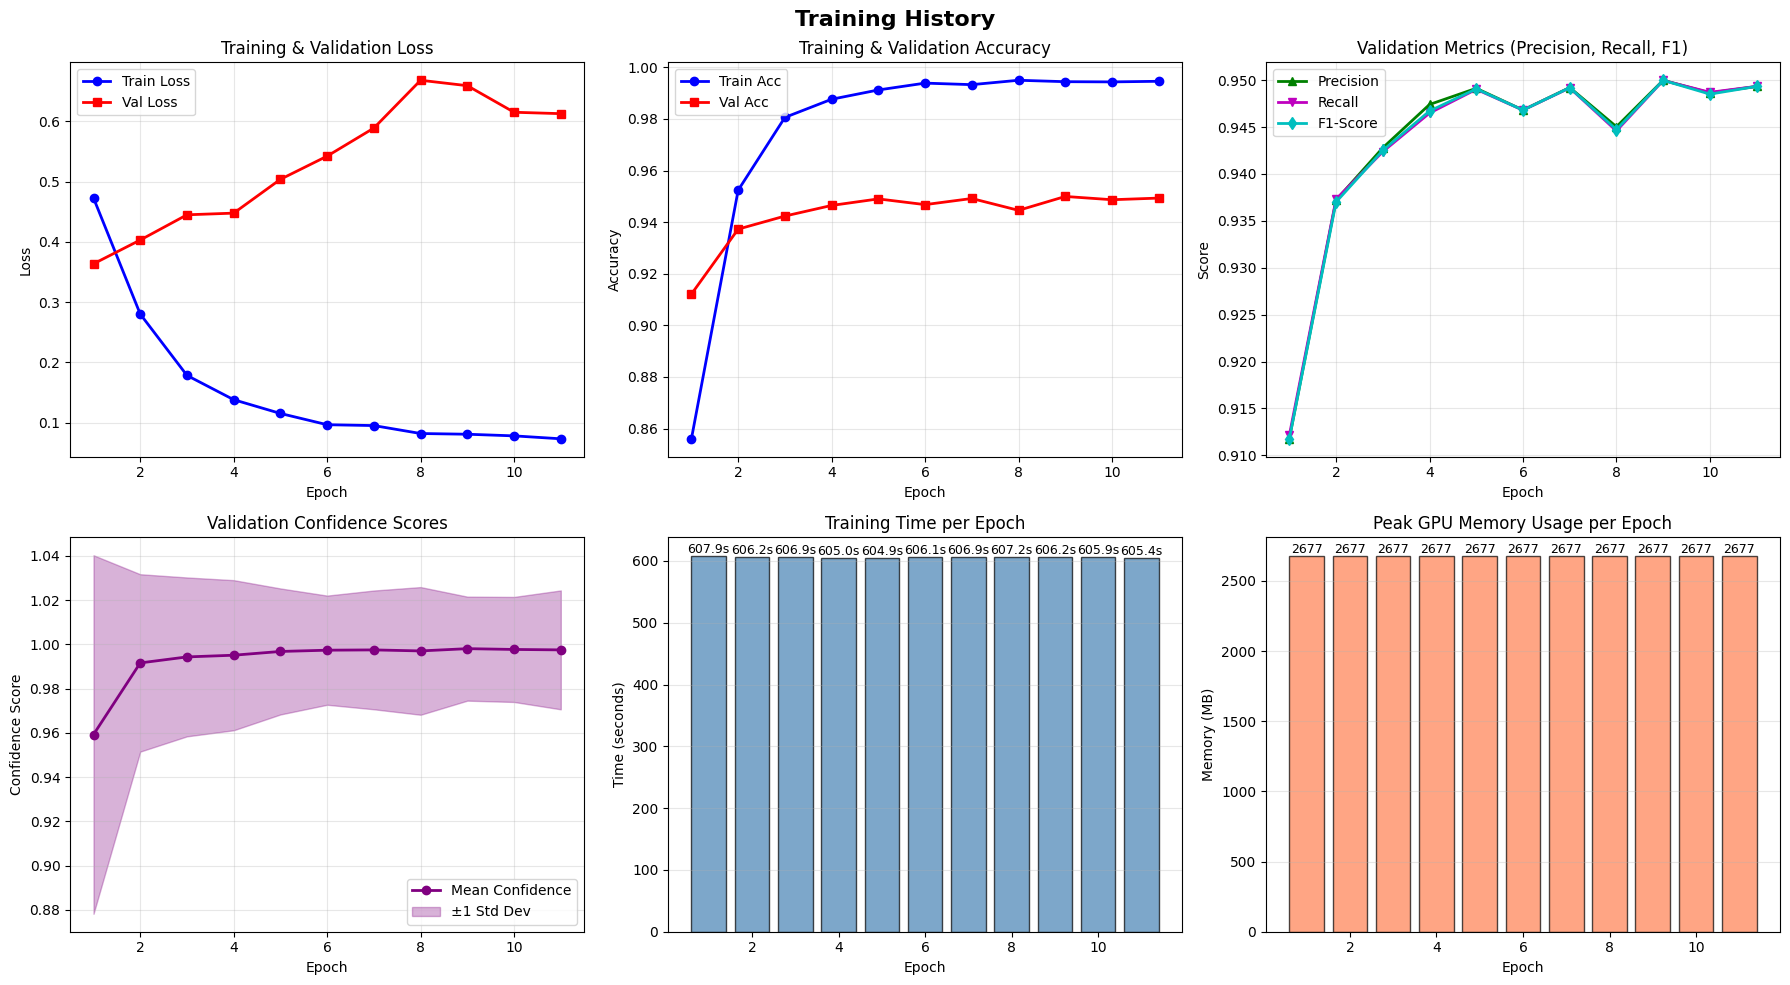

Saved training history plot to 'training_history.png'


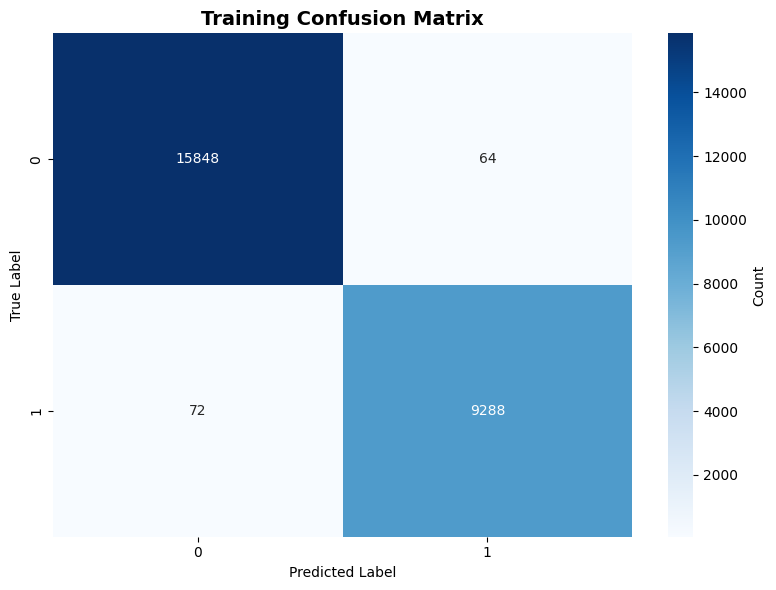

Saved Training Confusion Matrix to 'train_cm.png'

FINAL TEST EVALUATION

FINAL TEST RESULTS
Dataset: gab, Seed: 42, Freeze: yes, Epochs: 11
Test Accuracy     : 0.9462
Test Precision    : 0.9461
Test Recall       : 0.9462
Test F1-score     : 0.9461
Test Confidence Mean ± Std: 0.9978 ± 0.0247
Test Time (s)     : 51.79
Throughput (samples/sec): 107.65
Peak GPU Memory (MB): 2261.63

Classification Report:
                 precision     recall   f1-score    support
------------------------------------------------------------
              0       0.95       0.96       0.96       3513
              1       0.93       0.92       0.93       2062
       accuracy                             0.95       5575
      macro avg       0.94       0.94       0.94       5575
   weighted avg       0.95       0.95       0.95       5575

Confusion Matrix:
[[3374  139]
 [ 161 1901]]


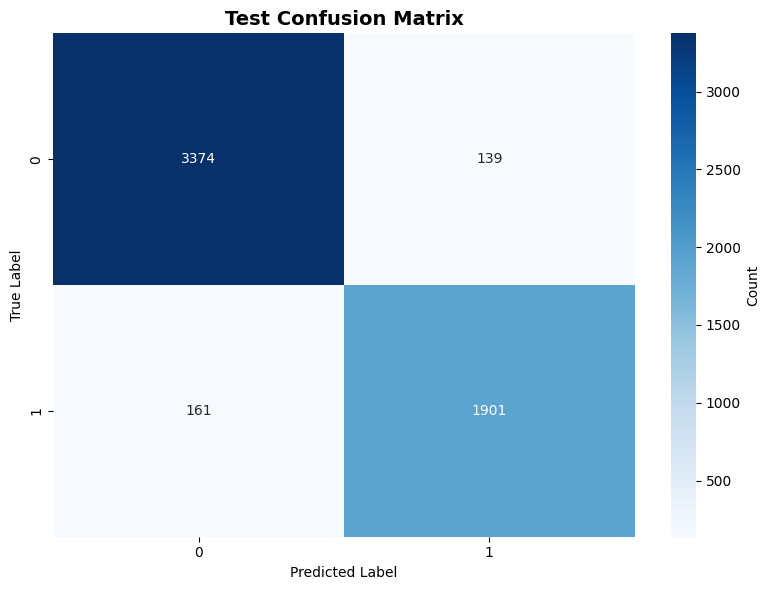

Saved Test Confusion Matrix to 'test_cm.png'

=== Rationale visualization ===
Sample 0 | True: 1 | Pred: 1 | Prob: N/A
[CLS]           : 1.000
what            : 0.000
the             : 0.000
dick            : 0.954
sucking         : 0.293
didn            : 0.000
##t             : 0.000
make            : 0.000
it              : 0.000
obvious         : 0.000
they            : 0.005
were            : 0.000
fa              : 0.989
##gg            : 1.000
##ots           : 0.898
[SEP]           : 1.000

Sample 1 | True: 1 | Pred: 1 | Prob: N/A
[CLS]           : 1.000
he              : 0.000
didn            : 0.000
##t             : 0.000
shoot           : 0.000
up              : 0.000
the             : 0.000
bar             : 0.000
cause           : 0.000
of              : 1.000
cha             : 1.000
##po            : 1.000
re              : 1.000
##tar           : 1.000
##d             : 1.000
he              : 0.000
hated           : 0.992
women           : 1.000
so              : 0.000

In [12]:
if __name__ == "__main__":
    import argparse
    import os
    import torch
    from transformers import AutoModel, AutoTokenizer

    parser = argparse.ArgumentParser()

    # Dataset and training args
    parser.add_argument("--reddit_csv", type=str,
                        default="/kaggle/input/datasets/toru1001/final-dataset-thesis/Mistral_Rationales_file_REDDIT_dataset(85-15).csv")

    parser.add_argument("--dataset", type=str, default="reddit") 
    parser.add_argument("--num_epochs", type=int, default=20)   
    parser.add_argument("--batch_size", type=int, default=8)
    parser.add_argument("--freeze_additional", choices=["yes","no"], default="yes")
    parser.add_argument("--max_length", type=int, default=128)
    parser.add_argument("--lr", type=float, default=2e-5)
    parser.add_argument("--show_visualizations", type=int, default=5)
    parser.add_argument("--seed", type=int, default=42)

    # CNN args
    parser.add_argument("--cnn_filters", type=int, default=128)
    parser.add_argument("--cnn_dropout", type=float, default=0.3)
    parser.add_argument("--cnn_kernels", nargs='+', type=int, default=[2,3,4,5,6,7])

    # Model names
    parser.add_argument("--hatebert_model_name", type=str, default="GroNLP/HateBERT")
    parser.add_argument("--rationale_model_name", type=str, default="bert-base-uncased")

    args, _ = parser.parse_known_args()

    print("=" * 60)
    print("LOADING MODELS")
    print("=" * 60)

    # Load pretrained models
    hatebert_model = AutoModel.from_pretrained(args.hatebert_model_name)
    rationale_model = AutoModel.from_pretrained(args.rationale_model_name)

    # Load tokenizers
    tokenizer_hatebert = AutoTokenizer.from_pretrained(args.hatebert_model_name)
    tokenizer_rationale = AutoTokenizer.from_pretrained(args.rationale_model_name)

    print("Models and tokenizers loaded successfully.")

    print("=" * 60)
    print("START TRAINING PIPELINE")
    print("=" * 60)

    # Train and evaluate
    model, history = train_and_evaluate(
        reddit_csv_path=args.reddit_csv,
        hatebert_model=hatebert_model,
        rationale_model=rationale_model,
        tokenizer_hatebert=tokenizer_hatebert,
        tokenizer_rationale=tokenizer_rationale,
        epochs=args.num_epochs,
        batch_size=args.batch_size,
        freeze_rationale=(args.freeze_additional.lower() == "yes"),
        max_length=args.max_length,
        lr=args.lr,
        show_visualizations=args.show_visualizations,
        seed=args.seed,
        cnn_num_filters=args.cnn_filters,
        cnn_kernel_sizes=tuple(args.cnn_kernels),
        cnn_dropout=args.cnn_dropout
    )

    print("=" * 60)
    print("TRAINING COMPLETE")
    print("=" * 60)

    # ================= SAVE MODEL =================

    save_dir = "/kaggle/working/models"
    os.makedirs(save_dir, exist_ok=True)

    save_path = f"{save_dir}/concat_model_{args.dataset}_modified_epochs{args.num_epochs}_seed{args.seed}.pth"

    torch.save({
        "model_state_dict": model.state_dict(),
        "history": history,
        "args": vars(args)
    }, save_path)

    print(f"Model saved to: {save_path}")